In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Figures for CVAE paper

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from synbio_morpher.utils.results.analytics.timeseries import calculate_adaptation
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict

# Figure 1

In [16]:
# fn_1127 = '../data/raw/summarise_simulation/2024_11_27_145142/tabulated_mutation_info.csv'
# fn_0129 = 
# ds_1127 = pd.read_csv(fn_1127)
# ds_0129 = 

# Figure 2

# Figure 3

In [ ]:
dir_contloss = 'data/cvae_multi/2025_03_26__15_54_26'
fn_df_hpos = os.path.join(dir_contloss, 'df_hpos.json')
fn_analytics = os.path.join(dir_contloss, 'analytics.json')
df_hpos = pd.read_json(fn_df_hpos)
analytics = load_json_as_dict(fn_analytics)
fake_circuits = np.load(os.path.join(dir_contloss, 'fake_circuits.npy'))
sampled_cond = np.load(os.path.join(dir_contloss, 'sampled_cond.npy'))

idx_output = -1
analytics.pop('RMSE')
for k, v in analytics.items():
    analytics[k] = np.array(v)
    
analytics['adaptation'] = calculate_adaptation(
    analytics['sensitivity'], analytics['precision'], alpha=2
)

In [ ]:
df_hpos_succ = df_hpos[df_hpos['run_successful']]
df_hpos_succ['Distribution overlap'] = df_hpos_succ['Overlap adaptation'].apply(
    lambda x: np.max([y for y in x['mean'] if y is not None])
)
eval_n_to_sample = df_hpos_succ['eval_n_to_sample'].values[0]
objective_chosen = 'adaptation'

d_plot = pd.DataFrame()
d_plot[objective_chosen] = analytics[objective_chosen][..., idx_output].flatten()
d_plot['Prompted condition'] = sampled_cond[..., 0].flatten().round(2)
d_plot['Temperature'] = np.repeat(df_hpos_succ['temperature'], repeats=eval_n_to_sample).values.round(2)
d_plot['Seed'] = np.repeat(df_hpos_succ['seed_train'], repeats=eval_n_to_sample).values.round(2)
d_plot['Distribution overlap'] = np.repeat(df_hpos_succ['Distribution overlap'], repeats=eval_n_to_sample).values.round(2)



/tmp/ipykernel_3509557/2806028073.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hpos_succ['Distribution overlap'] = df_hpos_succ['Overlap adaptation'].apply(


Text(0.5, 0.98, 'Objective: adaptation')

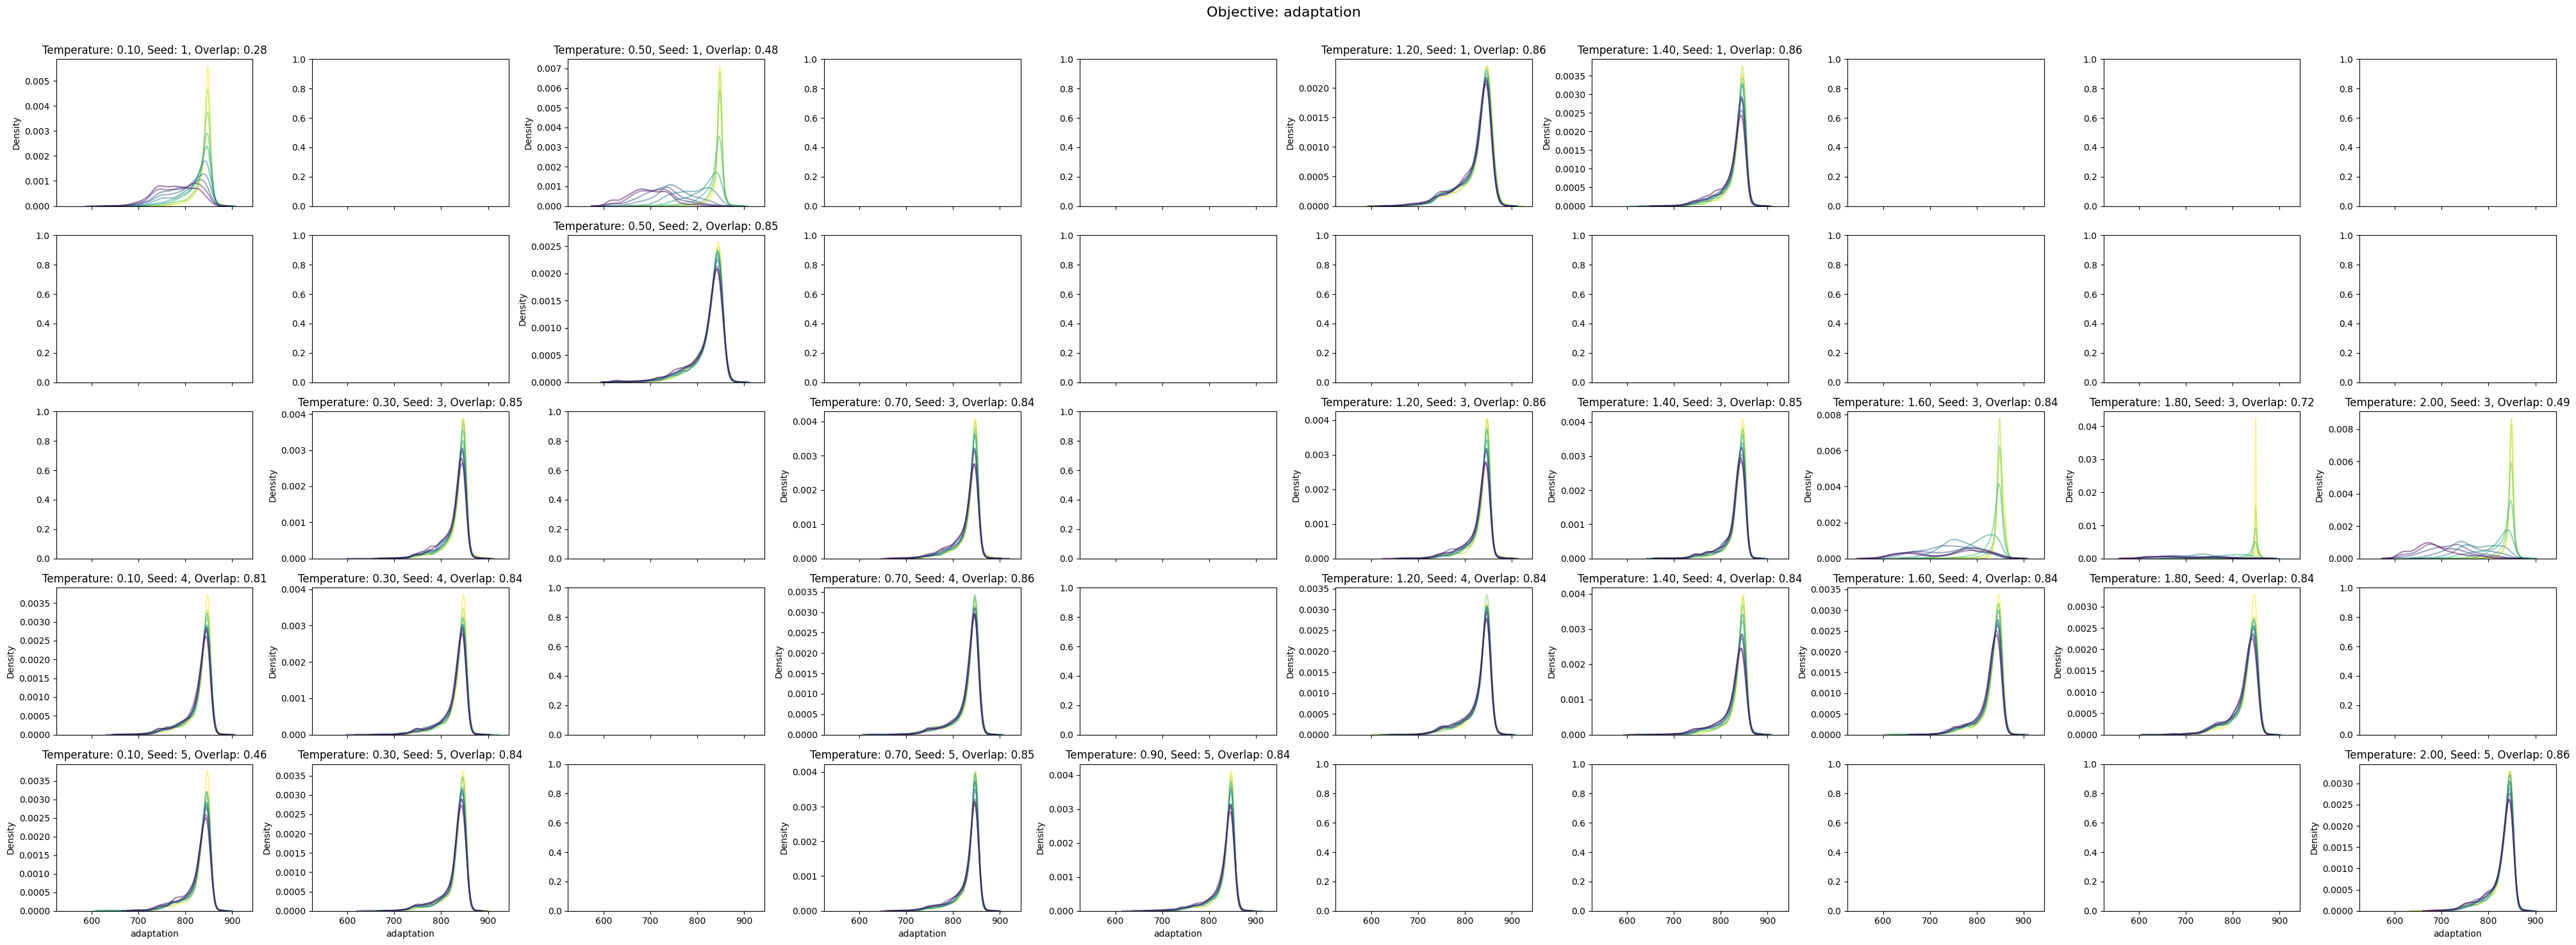

In [134]:
# sns.kdeplot(d_plot, x=objective_chosen, hue='Prompted condition')
ncols = d_plot['Temperature'].nunique()
nrows = d_plot['Seed'].nunique()
fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), sharey=False, sharex=True)
for i, t in enumerate(sorted(d_plot['Temperature'].unique())):
    for j, s in enumerate(sorted(d_plot['Seed'].unique())):
        filt = (d_plot['Temperature'] == t) & (d_plot['Seed'] == s)
        if d_plot[filt].shape[0] == 0:
            continue
        sns.kdeplot(d_plot[filt], x=objective_chosen, hue='Prompted condition', # bins=50, 
            palette='viridis', ax=axs[j, i], alpha=0.5, legend=False if i == 0 else False)
        axs[j, i].set_title(f'Temperature: {t:.2f}, Seed: {s}, Overlap: {d_plot[filt]["Distribution overlap"].values[0]:.2f}')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle(f'Objective: {objective_chosen}', fontsize=16)


# Figure 4